In [34]:
import os
import numpy as np
import glob
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, shape, mapping
import pandas as pd
import xarray as xr
import shapely.geometry as geometry
from geopandas import GeoDataFrame, GeoSeries
import time
import math

In [2]:
from shapely.geometry import MultiPoint

In [3]:
path = r'/home/Ritwika/PFZ_Parameter_Exploration/20200502/rproj_sendata/chl/'

In [4]:
path

'/home/Ritwika/PFZ_Parameter_Exploration/20200502/rproj_sendata/chl/'

## Making Mask Layer Polygons

In [5]:
nc_file_list = glob.glob(f'{path}*.nc')

In [6]:
ncfile = nc_file_list[6]

IndexError: list index out of range

In [129]:
ncfile = "S3A_OL_2_WFR____20200502T054952_20200502T055252_20200503T144640_0179_057_376_2520_MAR_O_NT_002_SEN3.nc"

In [145]:
DS.info()

xarray.Dataset {
dimensions:
	lat = 4141 ;
	lon = 4866 ;

variables:
	float32 CHL_OC4ME(lat, lon) ;
		CHL_OC4ME:units = mg.m-3 ;
		CHL_OC4ME:long_name = (OC4ME) Algal pigment concentration ;
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:standard_name = latitude ;
		lat:valid_min = 18.508023298121635 ;
		lat:valid_max = 31.45985182358407 ;
		lat:units = degrees_north ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:standard_name = longitude ;
		lon:valid_min = 55.70197600160166 ;
		lon:valid_max = 70.92193874951826 ;
		lon:units = degrees_east ;

// global attributes:
	:TileSize = 592:541 ;
	:start_date = 02-MAY-2020 05:51:21.689183 ;
	:stop_date = 02-MAY-2020 05:51:21.689183 ;
	:Conventions = CF-1.4 ;
}

In [372]:
start = time.time()

In [373]:
DS = xr.open_dataset(ncfile)

In [374]:
_mask = (DS['CHL_OC4ME']>254.9)

In [375]:
mask = np.copy(_mask)
mask.shape

(4141, 4866)

In [376]:
from matplotlib import pyplot as plt

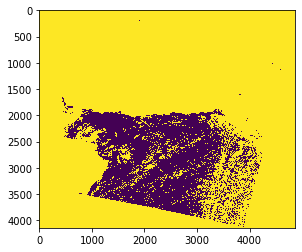

In [377]:
plt.imshow(mask)

In [378]:
resample_ratio = 3 # rr**2 guna kam karta hai points aur resolution ko

In [379]:
def resample(mask, resample_ratio):
    rows = mask.shape[0]
    cols = mask.shape[1]
    pad_rows = math.ceil(rows/resample_ratio)*resample_ratio - rows
    pad_cols = math.ceil(cols/resample_ratio)*resample_ratio - cols
    
    padded_mask = np.pad(mask, ((0, pad_rows), (0, pad_cols)), mode='edge')
    resample_mask = padded_mask.reshape((rows+pad_rows)//resample_ratio, resample_ratio, (cols+pad_cols)//resample_ratio, resample_ratio)
    resample_mask = np.rollaxis(resample_mask, 1, 3)
    resample_mask = resample_mask.reshape((resample_mask.shape[0], resample_mask.shape[1], -1))
    resample_mask = resample_mask.max(-1)
    return resample_mask

In [380]:
resample_ratio = 3 # rr**2 guna kam karta hai points aur resolution ko

In [381]:
rows = mask.shape[0]
cols = mask.shape[1]
pad_rows = math.ceil(rows/resample_ratio)*resample_ratio - rows
pad_cols = math.ceil(cols/resample_ratio)*resample_ratio - cols
pad_rows, pad_cols

(2, 0)

In [382]:
pad_rows, pad_cols

(2, 0)

In [383]:
padded_mask = np.pad(mask, ((0, pad_rows), (0, pad_cols)), mode='edge')
padded_mask.shape

(4143, 4866)

In [384]:
resample_mask = padded_mask.reshape((rows+pad_rows)//resample_ratio, resample_ratio, (cols+pad_cols)//resample_ratio, resample_ratio)
resample_mask.shape

(1381, 3, 1622, 3)

In [385]:
resample_mask = np.rollaxis(resample_mask, 1, 3)
resample_mask.shape

(1381, 1622, 3, 3)

In [386]:
resample_mask = resample_mask.reshape((resample_mask.shape[0], resample_mask.shape[1], -1))
resample_mask.shape

(1381, 1622, 9)

In [387]:
resample_mask = resample_mask.max(-1)
resample_mask.shape

(1381, 1622)

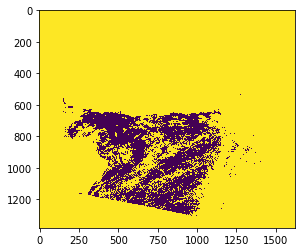

In [388]:
plt.imshow(resample_mask)

In [389]:
lats = np.repeat(np.copy(DS.lat), DS.lon.shape[0])
lons = np.repeat(np.copy(DS.lon), DS.lat.shape[0]).reshape(mask.T.shape).T.reshape(-1)
indices = np.argwhere(mask.reshape(-1))

In [390]:
lats = np.pad(np.copy(DS.lat), (0, pad_rows), mode='edge').reshape(-1, resample_ratio).mean(-1)
lats = np.repeat(lats, resample_mask.shape[1])
lons = np.pad(np.copy(DS.lon), (0, pad_cols), mode='edge').reshape(-1, resample_ratio).mean(-1)
lons = np.repeat(lons, resample_mask.shape[0]).reshape(resample_mask.T.shape).T.reshape(-1)
indices = np.argwhere(resample_mask.reshape(-1))

In [391]:
x = np.concatenate([lats[indices], lons[indices]], -1)

In [392]:
x

array([[31.45672336, 55.70510446],
       [31.45672336, 55.71448985],
       [31.45672336, 55.72387523],
       ...,
       [18.5080233 , 70.90003952],
       [18.5080233 , 70.90942491],
       [18.5080233 , 70.91881029]])

In [393]:
x.shape

(1931660, 2)

In [394]:
cell_size_y = DS.lat[0].item() - DS.lat[1].item()
cell_size_x = DS.lon[1].item() - DS.lon[0].item()

In [395]:
cell_size_y*=resample_ratio
cell_size_x*=resample_ratio

In [396]:
(DS.lat.max().item()-DS.lat.min().item())/8

1.6189785656828044

In [397]:
av_cell_size = (cell_size_y + cell_size_x)/2
av_cell_size

0.009385382989462343

In [398]:
y_min = x[:, 0] - (av_cell_size*3)/2
y_max = x[:, 0] + (av_cell_size*3)/2
x_min = x[:, 1]-(av_cell_size*3)/2
x_max = x[:, 1]+(av_cell_size*3)/2


In [399]:
cols = indices // resample_mask.shape[1]
cols

array([[   0],
       [   0],
       [   0],
       ...,
       [1380],
       [1380],
       [1380]], dtype=int64)

In [400]:
start = time.time()
poly_store = []
i = 0
while i < x.shape[0]:
    if i % 100 == 0:
        progress= i/x.shape[0]
        elapsed= time.time()-start
        eta = ((elapsed)/(i+1))*(x.shape[0]-i)
        message = f"Progres:{(progress*100):.2f} % | eta:{eta:.2f}s | elapsed:{elapsed:.2f}s"
        print(message, end='\r')
    #
    _x_min = x_min[i]
    _y_min = y_min[i]
    ri = i+1
    while ri < x.shape[0] and indices[i]+1 == indices[ri] and cols[i] == cols[ri]:
        i=i+1
        ri=ri+1
    _x_max = x_max[i]
    _y_max = y_max[i]
    #
    p = Polygon([(_x_min, _y_min), (_x_min, _y_max), (_x_max, _y_max),(_x_max, _y_min), (_x_min, _y_min)])
    poly_store.append(p)
    i+=1

In [401]:
len(poly_store)

39978

In [402]:
len(poly_store)

39978

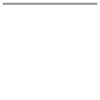

In [403]:
polygon = poly_store[2]
polygon

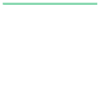

In [404]:
poly_line = polygon.boundary
poly_line

In [405]:
coords = list(poly_line.coords)

In [406]:
coords

[(55.69102638811395, 31.423874522124457),
 (55.69102638811395, 31.452030671092842),
 (70.93288836300596, 31.452030671092842),
 (70.93288836300596, 31.423874522124457),
 (55.69102638811395, 31.423874522124457)]

In [407]:
xy_s = [*coords[0], *coords[2]]

In [408]:
xy_s

[55.69102638811395, 31.423874522124457, 70.93288836300596, 31.452030671092842]

In [409]:
df = GeoDataFrame(geometry=GeoSeries(poly_store), crs={"init":"EPSG:4326"})
# area = df.geometry.area
# df_flt = df[area > 0.001]

In [410]:
df

geometry
0      POLYGON ((55.69103 31.44265, 55.69103 31.47080...
1      POLYGON ((55.69103 31.43326, 55.69103 31.46142...
2      POLYGON ((55.69103 31.42387, 55.69103 31.45203...
3      POLYGON ((55.69103 31.41449, 55.69103 31.44265...
4      POLYGON ((55.69103 31.40510, 55.69103 31.43326...
...                                                  ...
39973  POLYGON ((55.69103 18.52836, 55.69103 18.55651...
39974  POLYGON ((55.69103 18.51897, 55.69103 18.54713...
39975  POLYGON ((55.69103 18.50959, 55.69103 18.53774...
39976  POLYGON ((55.69103 18.50020, 55.69103 18.52836...
39977  POLYGON ((55.69103 18.49395, 55.69103 18.52210...

[39978 rows x 1 columns]

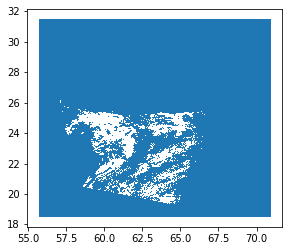

In [411]:
df.plot()

In [412]:
df['a'] = df.index//100

In [413]:
dissolved_df = df.dissolve(by='a').reset_index(drop=True)

In [414]:
dissolved_df

geometry
0    POLYGON ((55.69103 30.55103, 55.69103 30.56042...
1    POLYGON ((55.69103 29.61250, 55.69103 29.62188...
2    POLYGON ((55.69103 28.67396, 55.69103 28.68334...
3    POLYGON ((55.69103 27.74480, 55.69103 27.75419...
4    POLYGON ((55.69103 26.80627, 55.69103 26.81565...
..                                                 ...
395  MULTIPOLYGON (((64.35373 19.43874, 64.35373 19...
396  MULTIPOLYGON (((64.21295 19.37304, 64.21295 19...
397  MULTIPOLYGON (((64.55083 19.35427, 64.55083 19...
398  POLYGON ((70.93289 19.18534, 70.93289 19.17595...
399  POLYGON ((55.69103 18.49395, 55.69103 18.50020...

[400 rows x 1 columns]

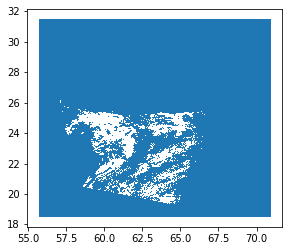

In [415]:
dissolved_df.plot()

In [417]:
time.time() - start

-27.244059801101685

In [125]:
mask = np.copy(mask).astype(int)

In [126]:
mask.shape

(4141, 4866)

In [127]:
mask[:-1] = mask[:-1] + mask[1:]
mask[:-2] = mask[:-2] + mask[2:]
mask[:-3] = mask[:-3] + mask[3:]
mask[:-4] = mask[:-4] + mask[4:]

In [128]:
mask.max()

16

In [120]:
mask.shape

(4141, 4866)

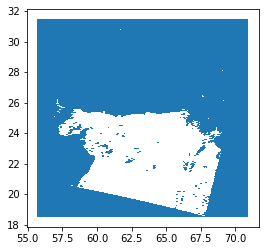

In [112]:
df_flt.plot()

In [103]:
geom_flt.dissolve()

AttributeError: 'GeoSeries' object has no attribute 'dissolve'

## Convex Hulls for Polygons instead of Dissolving and Buffering

In [26]:
original_arr = []
for polygon in poly_store:
    x_ys = []
    poly_line = polygon.boundary
    coords = list(poly_line.coords)
    x_ys = [*coords[0], *coords[2]]
    original_arr.append(x_ys)

In [27]:
original_arr

[[55.697283310106926,
  31.45515913208934,
  70.92663144101299,
  31.464544515078803],
 [55.697283310106926,
  31.45203067109285,
  70.92663144101299,
  31.461416054082314],
 [55.697283310106926,
  31.44890221009636,
  70.92663144101299,
  31.458287593085824],
 [55.697283310106926,
  31.44577374909987,
  70.92663144101299,
  31.455159132089335],
 [55.697283310106926,
  31.44264528810338,
  70.92663144101299,
  31.452030671092846],
 [55.697283310106926,
  31.439516827106896,
  70.92663144101299,
  31.44890221009636],
 [55.697283310106926,
  31.436388366110407,
  70.92663144101299,
  31.44577374909987],
 [55.697283310106926,
  31.433259905113918,
  70.92663144101299,
  31.44264528810338],
 [55.697283310106926,
  31.43013144411743,
  70.92663144101299,
  31.439516827106893],
 [55.697283310106926,
  31.42700298312094,
  70.92663144101299,
  31.436388366110403],
 [55.697283310106926,
  31.423874522124454,
  70.92663144101299,
  31.433259905113918],
 [55.697283310106926,
  31.420746061127964

In [28]:
#Convert list into array
original_arr = np.array(original_arr) 

In [29]:
#inexes of the array
indexes = np.arange(0, len(original_arr), dtype=np.int32)
indexes

array([     0,      1,      2, ..., 454517, 454518, 454519], dtype=int32)

In [30]:
import random

In [31]:
#selection of first random point indx
first_point = random.randint(0, len(original_arr)-1)
first_point

135324

In [32]:
non_popped_indices = indexes

In [33]:
#coordinate details of the random point
xys = original_arr[first_point, [[0, 1], [0, 3], [2, 1], [2, 3]]]

In [34]:
xys

array([[68.21425576, 23.00518598],
       [68.21425576, 23.01457136],
       [68.2267696 , 23.00518598],
       [68.2267696 , 23.01457136]])

In [61]:
buffer_dist = 10*av_cell_size

In [62]:
for [x, y] in xys:
    print([x,y])
    arr = original_arr[non_popped_indices]
     # Xmin , Ymin is near to point
    case1 = ((np.abs(arr[:, [0, 1]] - [x, y]) < buffer_dist)).all(-1)
    # Xmin , Ymax is near to point
    case2 = ((np.abs(arr[:, [0, 3]] - [x, y]) < buffer_dist)).all(-1)
    # Xmax , Ymax is near to point
    case3 = ((np.abs(arr[:, [2, 1]] - [x, y]) < buffer_dist)).all(-1)
    # Xmax , Ymin is near to point
    case4 = ((np.abs(arr[:, [2, 3]] - [x, y]) < buffer_dist)).all(-1)
    combine = (case1 | case2 | case3 | case4)
    near_indexes = np.argwhere(combine) 
    near_indexes = non_popped_indices[near_indexes].reshape(-1)

[67.3601859050161, 18.84120439424766]
[67.3601859050161, 18.850589777237126]
[67.36957128800555, 18.84120439424766]
[67.36957128800555, 18.850589777237126]


In [63]:
arr[0]

array([55.69728331, 31.45515913, 70.92663144, 31.46454452])

In [64]:
case1

array([False, False, False, ..., False, False, False])

In [65]:
len(arr)

454520

In [66]:
near_indexes.shape

(86,)

In [67]:
popped_indexes = np.concatenate([np.array([first_point]), near_indexes])
left_indexes = np.argwhere(~np.isin(indexes, popped_indexes)).reshape(-1)
left_indexes.shape

(454433,)

In [68]:
near_indexes

array([450537, 450538, 450539, 450540, 450614, 450615, 450616, 450617,
       450618, 450619, 450698, 450699, 450700, 450773, 450774, 450847,
       450848, 450849, 450850, 450851, 450930, 450931, 450932, 450933,
       451021, 451022, 451023, 451024, 451025, 451091, 451092, 451093,
       451094, 451095, 451161, 451162, 451163, 451164, 451231, 451232,
       451299, 451300, 451301, 451302, 451369, 451370, 451371, 451372,
       451373, 451374, 451444, 451445, 451446, 451447, 451448, 451525,
       451526, 451527, 451528, 451609, 451610, 451611, 451612, 451683,
       451684, 451685, 451686, 451748, 451749, 451750, 451814, 451815,
       451816, 451817, 451894, 451895, 451965, 451966, 451967, 452029,
       452030, 452031, 452032, 452101, 452102, 452103], dtype=int32)

In [69]:
np.array([first_point]) #It can be seen that first point index is in near index 

array([135324])

In [70]:
popped_indexes

array([135324, 450537, 450538, 450539, 450540, 450614, 450615, 450616,
       450617, 450618, 450619, 450698, 450699, 450700, 450773, 450774,
       450847, 450848, 450849, 450850, 450851, 450930, 450931, 450932,
       450933, 451021, 451022, 451023, 451024, 451025, 451091, 451092,
       451093, 451094, 451095, 451161, 451162, 451163, 451164, 451231,
       451232, 451299, 451300, 451301, 451302, 451369, 451370, 451371,
       451372, 451373, 451374, 451444, 451445, 451446, 451447, 451448,
       451525, 451526, 451527, 451528, 451609, 451610, 451611, 451612,
       451683, 451684, 451685, 451686, 451748, 451749, 451750, 451814,
       451815, 451816, 451817, 451894, 451895, 451965, 451966, 451967,
       452029, 452030, 452031, 452032, 452101, 452102, 452103])

In [71]:
from shapely.geometry import MultiPolygon

In [72]:
original_arr[near_indexes]

array([[67.3289013 , 18.87874593, 67.34141514, 18.88813131],
       [67.33828668, 18.87874593, 67.36331437, 18.88813131],
       [67.36018591, 18.87874593, 67.38208513, 18.88813131],
       [67.38208513, 18.87874593, 67.43214051, 18.88813131],
       [67.30700207, 18.87561747, 67.34141514, 18.88500285],
       [67.33828668, 18.87561747, 67.34767206, 18.88500285],
       [67.3445436 , 18.87561747, 67.36644283, 18.88500285],
       [67.36331437, 18.87561747, 67.37582821, 18.88500285],
       [67.37895667, 18.87561747, 67.39459898, 18.88500285],
       [67.39147051, 18.87561747, 67.42901205, 18.88500285],
       [67.32577283, 18.872489  , 67.37895667, 18.88187439],
       [67.37582821, 18.872489  , 67.38521359, 18.88187439],
       [67.38208513, 18.872489  , 67.41336974, 18.88187439],
       [67.32577283, 18.86936054, 67.38208513, 18.87874593],
       [67.38208513, 18.86936054, 67.41336974, 18.87874593],
       [67.31638745, 18.86623208, 67.35705744, 18.87561747],
       [67.35392898, 18.

In [73]:
x = original_arr[near_indexes][1]

In [74]:
x

array([67.33828668, 18.87874593, 67.36331437, 18.88813131])

In [75]:
near_indexes

array([450537, 450538, 450539, 450540, 450614, 450615, 450616, 450617,
       450618, 450619, 450698, 450699, 450700, 450773, 450774, 450847,
       450848, 450849, 450850, 450851, 450930, 450931, 450932, 450933,
       451021, 451022, 451023, 451024, 451025, 451091, 451092, 451093,
       451094, 451095, 451161, 451162, 451163, 451164, 451231, 451232,
       451299, 451300, 451301, 451302, 451369, 451370, 451371, 451372,
       451373, 451374, 451444, 451445, 451446, 451447, 451448, 451525,
       451526, 451527, 451528, 451609, 451610, 451611, 451612, 451683,
       451684, 451685, 451686, 451748, 451749, 451750, 451814, 451815,
       451816, 451817, 451894, 451895, 451965, 451966, 451967, 452029,
       452030, 452031, 452032, 452101, 452102, 452103], dtype=int32)

In [76]:
points = []
for i in near_indexes:
    poly = original_arr[i,[[0, 1], [0, 3], [2, 1], [2, 3]]]
    #print(poly)
    for m in poly:
        m = Point(m)
        #print(m)
        points.append(m)

In [77]:
points

In [78]:
points_xys = []
for n in xys:
    n = Point(n)
    #print(m)
    points_xys.append(n)

In [79]:
mp = MultiPoint(points+points_xys)

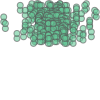

In [80]:
mp

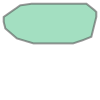

In [81]:
ch = mp.convex_hull
ch

In [82]:
convex_hull_store = [ch]

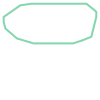

In [83]:
line = ch.boundary
line

In [84]:
x_ys = list(line.coords)
x_ys

[(67.3320297560477, 18.813048245279266),
 (67.30074514608282, 18.822433628268733),
 (67.2788459191074, 18.84120439424766),
 (67.2757174581109, 18.85371823823362),
 (67.2757174581109, 18.863103621223082),
 (67.30700206807579, 18.8850028481985),
 (67.32890129505121, 18.88813130919499),
 (67.43214050793532, 18.88813130919499),
 (67.44778281291777, 18.875617465209032),
 (67.45091127391424, 18.872489004212547),
 (67.45091127391424, 18.863103621223082),
 (67.44152589092478, 18.82556208926522),
 (67.42588358594234, 18.81930516727224),
 (67.40711281996342, 18.813048245279266),
 (67.3320297560477, 18.813048245279266)]

In [85]:
def get_near_indices(x_ys, non_popped_indices):
    arr = original_arr[non_popped_indices]
    for [x, y] in x_ys:
         # Xmin , Ymin is near to point
        case1 = ((np.abs(arr[:, [0, 1]] - [x, y]) < buffer_dist)).all(-1)
        # Xmin , Ymax is near to point
        case2 = ((np.abs(arr[:, [0, 3]] - [x, y]) < buffer_dist)).all(-1)
        # Xmax , Ymax is near to point
        case3 = ((np.abs(arr[:, [2, 1]] - [x, y]) < buffer_dist)).all(-1)
        # Xmax , Ymin is near to point
        case4 = ((np.abs(arr[:, [2, 3]] - [x, y]) < buffer_dist)).all(-1)
        combine = (case1 | case2 | case3 | case4)
        near_indexes = np.argwhere(combine) 
        near_indexes = non_popped_indices[near_indexes].reshape(-1)
    return near_indexes

In [86]:
print(near_indexes.shape)
print(popped_indexes.shape)
print(left_indexes.shape)
append_ch = False
while True:
    near_indexes = get_near_indices(x_ys, left_indexes)
    print(near_indexes.shape)
    popped_indexes = np.concatenate([popped_indexes, near_indexes])
    print(popped_indexes.shape)
    left_indexes = (left_indexes[(~np.isin(left_indexes, popped_indexes))]).reshape(-1) # Index is not in popped indexes
    print(left_indexes.shape)
    if near_indexes.shape[0] > 2:
        print(True)
        points = []
        for i in near_indexes:
            poly = original_arr[i,[[0, 1], [0, 3], [2, 1], [2, 3]]]
            #print(poly)
            for m in poly:
                m = Point(m)
                #print(m)
                points.append(m)
        mp = MultiPoint(points)
        ch = mp.convex_hull
        append_ch = True
        line = ch.boundary
        x_ys = list(line.coords)
        continue

    # No more near points found
    if append_ch:
        print("appended this convex hull")
        convex_hull_store.append(ch)
        append_ch = False
    #
    print("getting a new point")
    if left_indexes.shape[0] > 1:
        point = random.randint(0, left_indexes.shape[0]-1) # Get a random point
        orig_index = left_indexes[point]
        left_indexes = np.delete(left_indexes, point)
        popped_indexes = np.concatenate([popped_indexes, [orig_index]])
        print("--new point", orig_index)
        xys = original_arr[orig_index, [[0, 1], [0, 3], [2, 1], [2, 3]]]
    else:        
        if left_indexes.shape[0] > 0:
            popped_indexes = np.concatenate([popped_indexes, left_indexes])
            left_indexes = np.delete(left_indexes, 0)
        break

(86,)
(87,)
(454433,)
(61,)
(148,)
(454372,)
True
(63,)
(211,)
(454309,)
True
(77,)
(288,)
(454232,)
True
(42,)
(330,)
(454190,)
True
(18,)
(348,)
(454172,)
True
(12,)
(360,)
(454160,)
True
(12,)
(372,)
(454148,)
True
(12,)
(384,)
(454136,)
True
(7,)
(391,)
(454129,)
True
(0,)
(391,)
(454129,)
appended this convex hull
getting a new point
--new point 103633
(0,)
(392,)
(454128,)
getting a new point
--new point 166218
(0,)
(393,)
(454127,)
getting a new point
--new point 230347
(0,)
(394,)
(454126,)
getting a new point
--new point 120795
(0,)
(395,)
(454125,)
getting a new point
--new point 40213
(0,)
(396,)
(454124,)
getting a new point
--new point 335558
(0,)
(397,)
(454123,)
getting a new point
--new point 288261
(0,)
(398,)
(454122,)
getting a new point
--new point 434993
(0,)
(399,)
(454121,)
getting a new point
--new point 297186
(0,)
(400,)
(454120,)
getting a new point
--new point 83993
(0,)
(401,)
(454119,)
getting a new point
--new point 395643
(0,)
(402,)
(454118,)
getting a 

KeyboardInterrupt: 

In [87]:
orig_index

164978

In [88]:
x_ys

[(55.697283310106926, 18.503330606626903),
 (55.697283310106926, 18.531486755595296),
 (70.92663144101299, 18.531486755595296),
 (70.92663144101299, 18.503330606626903),
 (55.697283310106926, 18.503330606626903)]

In [89]:
buffer_dist

0.03128460996487448

In [30]:
len(poly_coord)

454520

In [31]:
indexes = np.arange(0, len(poly_coord), dtype=np.int32)

In [32]:
indexes

array([     0,      1,      2, ..., 454517, 454518, 454519], dtype=int32)

In [ ]:
def get_near_indices(x_ys, non_popped_indices, lats, lons):
    store = []
    for [x_min, x_max,y_min,y_max] in poly:
        fp_indexes = np.argwhere((np.abs(lats[non_popped_indices] - y_min) < buffer_dist) or (np.abs(lats[non_popped_indices] - y_max) < buffer_dist) or (np.abs(lons[non_popped_indices] - x_min) < buffer_dist) or (np.abs(lons[non_popped_indices] - x_max) < buffer_dist)).reshape(-1)

In [16]:
invalid_gdf = GeoDataFrame(geometry=GeoSeries(poly_store, crs={'init': 'epsg:4326'}))

/home/Ritwika/anaconda3/envs/geo/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
invalid_gdf

geometry
0       POLYGON ((55.70041 31.45829, 55.70041 31.46142...
1       POLYGON ((55.70041 31.45516, 55.70041 31.45829...
2       POLYGON ((55.70041 31.45203, 55.70041 31.45516...
3       POLYGON ((55.70041 31.44890, 55.70041 31.45203...
4       POLYGON ((55.70041 31.44577, 55.70041 31.44890...
...                                                   ...
454515  POLYGON ((55.70041 18.51897, 55.70041 18.52210...
454516  POLYGON ((55.70041 18.51584, 55.70041 18.51897...
454517  POLYGON ((55.70041 18.51272, 55.70041 18.51584...
454518  POLYGON ((55.70041 18.50959, 55.70041 18.51272...
454519  POLYGON ((55.70041 18.50646, 55.70041 18.50959...

[454520 rows x 1 columns]

In [19]:
#points2 = invalid_gdf.copy()

In [ ]:
# points2.geometry = points2.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))
# points2.head()

In [17]:
poly_store

 ...]

In [20]:
invalid_gdf['geometry']

0         POLYGON ((55.70041 31.45829, 55.70041 31.46142...
1         POLYGON ((55.70041 31.45516, 55.70041 31.45829...
2         POLYGON ((55.70041 31.45203, 55.70041 31.45516...
3         POLYGON ((55.70041 31.44890, 55.70041 31.45203...
4         POLYGON ((55.70041 31.44577, 55.70041 31.44890...
                                ...                        
454515    POLYGON ((55.70041 18.51897, 55.70041 18.52210...
454516    POLYGON ((55.70041 18.51584, 55.70041 18.51897...
454517    POLYGON ((55.70041 18.51272, 55.70041 18.51584...
454518    POLYGON ((55.70041 18.50959, 55.70041 18.51272...
454519    POLYGON ((55.70041 18.50646, 55.70041 18.50959...
Name: geometry, Length: 454520, dtype: geometry